Код для скрытия ячеек с кодом (можно открыть, нажав кнопку)

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true;
function code_toggle() {
if (code_show){
$('div.input').hide();
} else {
$('div.input').show();
}
code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
import gym
import numpy as np
import math as m
import random
import os
import multiprocessing as mp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.axes import Axes
from gym.envs.toy_text import BlackjackEnv
from tqdm.notebook import tqdm
from time import time

# Часть первая, с блекджеком и стратегиями

In [3]:
env = gym.make('Blackjack-v0', natural=False)

In [4]:
def simple_model(treshhold, n_model):
    """
    Подсчет ожидания среднего выигрыша
        treshhold - порог очков в руке игрока до которого игрок берет дополнительные карты
        n_model - количество партий игры
        """
    summ = 0
    
    for i in range(0, n_model):
        state = env.reset()
        done = False
        while not done:
            if state[0] < treshhold:
                new_state, reward, done, _ = env.step(1)
                state = new_state
            else:
                new_state, reward, done, _ = env.step(0)

        summ += reward
    return summ / n_model

Простая стратегия: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit.

In [5]:
out = []
range_ = np.arange(16, 22)
for i in tqdm(range_):
    out.append(simple_model(i, 100000))

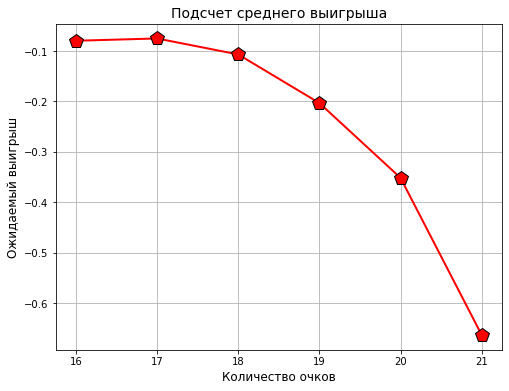

In [6]:
plt.figure(figsize=(8, 6))

plt.title('Подсчет среднего выигрыша',
          fontdict={'fontsize': 14},
         )

plt.plot(range_, np.array(out),
         '-p',
         color='red',
         markersize=15,
         linewidth=2,
         #markerfacecolor='white',
         markeredgecolor='black',
        );
plt.xlabel('Количество очков',
           fontdict={'fontsize': 12},
          );
plt.ylabel('Ожидаемый выигрыш',
           fontdict={'fontsize': 12},
          );
plt.xticks(range_)
plt.grid()

In [7]:
for key, value in zip(range_, out):
    print('Ожидаемый выигрыш {}, при количестве очков ну руках {}'.format(value, key))

Ожидаемый выигрыш -0.07973, при количестве очков ну руках 16
Ожидаемый выигрыш -0.0752, при количестве очков ну руках 17
Ожидаемый выигрыш -0.10684, при количестве очков ну руках 18
Ожидаемый выигрыш -0.20319, при количестве очков ну руках 19
Ожидаемый выигрыш -0.35157, при количестве очков ну руках 20
Ожидаемый выигрыш -0.66303, при количестве очков ну руках 21


## Использование модели Q-обучения

Отрисовка стратегий

In [8]:
def heat_map_plot(matrix: np.array, double=True):
    data = pd.DataFrame(matrix)
    data.columns = list(map(str, np.arange(4, 22)))
    data.index = ['A', '2', '3', '4', '5', '6', '7', '8', '9', '10']
    
    plt.figure(figsize=(10, 6)) 
 
    if double:
        n = 2
        title = 'Стратегии игры (2-double, 1 - hit, 0 - stand)'
    else:
        n = 1
        title = 'Стратегии игры (1 - hit, 0 - stand)'
        
    cbar_kws = {"orientation": "vertical", 
                "shrink":1,
                'extend':'min', 
                'extendfrac':0.1, 
                "ticks":np.arange(0, n+1), 
                "drawedges":False, 
               }
 
    sns.heatmap(data,
                vmin=0,
                vmax=n,
                cmap="coolwarm",
                annot = True,
                linewidth = 1,
                cbar_kws=cbar_kws)

    plt.yticks(rotation=0) 

    plt.title(title, fontsize=14)
    plt.xlabel("Очки на руках игра", fontsize=12)
    plt.ylabel("Карты на руках у дилера", fontsize=12)
    plt.show()

In [9]:
class QLerning():
    '''
    Обучение поведения агента алгоритмом QL
    
    '''
    
    def __init__(self, model, alpha=0.5, gamma=0.5, epsilon=0.0):
        # Модель поведения агента
        self._model = model
        # Матрица полезности для агента определенная в модели
        self._matrix_q = model.get_matrix_q()
        # Матрица полезности выдающая максимальное среднее значение выигрыша
        self._best_matrix_q = self._matrix_q.copy()
        # Фактор обучения. Чем он выше, тем сильнее агент доверяет новой информации.
        self.alpha = alpha
        # Фактор дисконтирования. Чем он меньше, тем меньше агент задумывается о выгоде от будущих своих действий.
        self.gamma = gamma
        self.epsilon = epsilon
        self._mean_reward = -1000
        self._mean_reward_from_iter = -1000
        self._game_is_done = False
        self._last_state = self._model._min_state
        self._last_action = 0
        self._last_reward = 0

        
    def _choice_action(self, current_state):
        '''
        Выбор действия по матрице полезности от текущего состояния
        
        '''
        
        if random.random() < epsilon:
            row = random.choice(self.model.space_action)
        else:
            row, col = self._model.convert_state_action_to_index_matrix_q(current_state, 0)
        return np.argmax(self._matrix_q[row, :])
     
        
    def _update_matrix_q(self,):
        '''
        Обновление матрицы полезности для предыдущего шага
        
        '''
        
        current_index, _ = self._model.convert_state_action_to_index_matrix_q(self._current_state, 0)
        last_index = self._model.convert_state_action_to_index_matrix_q(self._last_state, self._last_action)
        
        self._max_q = max(self._matrix_q[current_index, :])
        self._matrix_q[last_index] += self.alpha * (self._last_reward + self.gamma * self._max_q - self._matrix_q[last_index])    
    
    
    def _update_state_action(self,):
        """
        Обновление параметров состояний и действий
            Метод get_new_state(action) в модели поведения возвращает значения параметров 
            после совершения действия над средой:
                - значение текущего состояния агента;
                - награду за переход в текущее состояние агента;
                - флаг определяющий состояние игры (True - игра закончена, False - игра продолжается)
        
        """
        
        # Переопределение значений для предыдущего шага
        self._last_state = self._current_state
        self._last_action = self._current_action
        
        # Определение значений для текущего шага
        new_state, reward, self._game_is_done = self._model.get_new_state_from_lerning(self._current_state, self._last_action)
        if self._game_is_done == False:
            self._current_state = new_state
            self._current_action = self._model.choice_action(self._current_state)
        self._last_reward = reward
    
    
    def _one_game_traning(self,):
        """
        Обучение на одной игре
        
        """
        
        self._game_is_done = False
        self._model.reset_game()
        self._current_state = self._model.get_current_state()
        self._current_action = self._model.choice_action(self._current_state)

        while self._game_is_done == False:            
            self._update_matrix_q()
            self._update_state_action()
    
    
    def traning_model(self, 
                      n_train = 1000,
                      show_fit = False,
                      delta_show = 10, 
                      n_games = 10000):     
        """
        Обучение для n_train игр
            n_train - число итераций для тренировки модели поведения в среде
            show_fit - флаг отвечающий за отображение изменения среднего выигрыша в процессе обучения
            delta_show - через сколько итераций n_train показывать изменение среднего выигрыша в процессе обучения
            n_games - число игр, для подсчета среднего выигрыша
            
        """
        
        if show_fit:
            self._fig, self._ax = plt.subplots()
            list_mean_rewards = []
            list_i = []
            plt.ion()
        
        for i in tqdm(range(n_train)):
            self._one_game_traning()
            # Обработчик события отрисовки
            if show_fit and i%delta_show == 0:
                self._model.game(matrix_q=self._matrix_q, n_games=n_games)
                self._mean_reward = self._model.get_mean_reward()
                # Обновление информации о лучшей матрице полезности
                if self._mean_reward > self._mean_reward_from_iter:
                    self._mean_reward_from_iter = self._mean_reward
                    print("Best iteration value: ", self._mean_reward_from_iter)
                    self._best_matrix_q = self._matrix_q.copy()
                
                list_mean_rewards.append(self._mean_reward)
                list_i.append(i)
                # Отрисовка среднего выигрыша
                self._draw_plot(list_i, list_mean_rewards)
        
        if show_fit:
            print("Best value: ", self._mean_reward_from_iter)
            plt.ioff() 
    
    
    def get_mean_reward(self):
        '''
        Вывод текущего среднего выигрыша
        
        '''
        
        return self._mean_reward
    
    
    def get_matrix_q(self):
        '''
        Вывод текущей матрицы полезности
        
        '''
        
        return self._matrix_q

    
    def get_best_mean_reward(self):
        '''
        Вывод лучшего среднего выигрыша
        
        '''
        
        return self._mean_reward_from_iter
    
    
    def get_best_matrix_q(self):
        '''
        Вывод лучшей матрицы полезности'
        
        '''
        
        return self._best_matrix_q
    
    
    def _draw_plot(self, data_x, data_y):
        '''
        Отрисовка значений среднего выигрыша
        
        '''
        
        self._ax.clear()
        self._ax.plot(data_x, data_y, color='red')
        self._ax.set_title('Зависимость среднего выигрыша от количества итераций обучения',
                           fontdict={'fontsize': 12},
                          )
        self._ax.set_ylabel('Средний выигрыш',
                            fontdict={'fontsize': 10},
                           )
        self._ax.set_xlabel('Итерация обучения',
                            fontdict={'fontsize': 10},
                           )
        self._fig.canvas.draw()

### Простая модель

In [10]:
class BaseModel(BlackjackEnv):
    '''
    Простая модель игры в блэкджэк
    
    '''
    
    def __init__(self, natural=True, matrix_q=None, multiproc_game=False, n_cpu=mp.cpu_count()):
        super(BaseModel, self).__init__(natural)
        self.space_action = np.arange(2)
        # Минимально возможное значнение карт на руках
        self._min_state = 4
        self._mean_reward = 0
        self._current_state = self._min_state

        self.replace_matrix_q(matrix_q)
        
        self._mulitiproc_game = multiproc_game
        self._n_cpu=n_cpu

        
    def _one_game_until_reset_deck(self):
        sum_reward = 0
        party = 0
        self.reset_game()
        done = False
        while done == False:
            action = self.choice_action(self._current_state)
            new_state, reward, done = self.get_new_state(action)
            if done == False:
                self._current_state = new_state
        sum_reward += reward
        party += 1
        self.reset_game()
        return sum_reward, party  
    
    
    def _game_multiproc(self, n_games=10000, seed=time()):
        count = 0
        reward = 0
        _seed = mp.current_process().name.split('-')
        if _seed[0] == 'MainProcess':
            _seed = seed
        else:
            _seed = _seed[1]
        np.random.seed(int(_seed))
        while count < n_games:
            rew, par = self._one_game_until_reset_deck()
            reward += rew
            count += par 
        return reward, count
   

    def _game_one_proc(self, n_games = 10000):
        '''
        Инициализации n_games партий
        
        '''
        sum_reward = 0
        for i in range(n_games):
            self.reset_game()
            done = False
            while not done:
                action = self.choice_action(self._current_state)
                new_state, reward, done = self.get_new_state(action)
                if not done:
                    self._current_state = new_state
            sum_reward += reward    
        self._mean_reward = sum_reward / n_games
    
    
    def game(self, n_games = 10000, matrix_q=None):
        '''
        Инициализации n_games партий'
        
        '''
        
        if isinstance(matrix_q, np.ndarray):
             self.replace_matrix_q(matrix_q)
        if self._mulitiproc_game:
            pool = mp.Pool(processes=self._n_cpu)
            chunk = int(n_games/self._n_cpu)
            result = pool.map(self._game_multiproc, np.ones(self._n_cpu)*chunk)
            _sum = np.sum(result, axis=0)
            self._mean_reward = _sum[0]/_sum[1]
        else:
            self._game_one_proc(n_games=n_games)

            
    def reset_game(self,):
        state = self.reset()
        self._current_state = state[0]
   

    def choice_action(self, current_state):
        '''
        Выбор действия по матрице полезности от текущего состояния
        current_state - текущее состояние
        
        '''
        
        row, col = self.convert_state_action_to_index_matrix_q(current_state, 0)
        return np.argmax(self._matrix_q[row,:])
     
    def get_current_state(self,):
        return self._current_state
    
    
    def get_new_state(self, action):
        '''
        Возвращение нового состояния, награды и флага состояния игры после действия
        
        '''
        
        state, reward, done, _ = self.step(action)
        return state[0], reward, done
    
    
    def get_new_state_from_lerning(self, current_state, action):
        '''
        Возвращение нового состояния, награды и флага состояния игры после действия
        
        '''
        
        return self.get_new_state(action)
    
    
    def convert_state_action_to_index_matrix_q(self, state, action):
        """
        Конвертация состояния и действия в позицию строки и столбца матрицы полезности
        
        """
        
        return (self.dealer[0] - 1)* 18 + state - self._min_state, action
    
    
    def get_matrix_q(self,):
        """
        Возвращение текущей матрицы полезности
        
        """
        
        return self._matrix_q
    
    
    def get_mean_reward(self,):
        """
        Возвращение среднего выигрыша
        
        """
        
        return self._mean_reward 
    
    
    def get_matrix_actions(self, matrix_q, n_col=1):
        """
        Вывод матрицы действий в зависимости от состояний
        
        """
        
        return np.argmax(matrix_q, axis=1).reshape(-1, n_col)
    
    
    def replace_matrix_q(self, new_matrix_q):
        """
        Замена текущей матрицы полезности
            new_matrix_q - матрица для замены
            
        """
        
        if isinstance(new_matrix_q, np.ndarray):
            size = new_matrix_q.shape
            assert size == (180, 2), 'Размер матрицы полезности должен быть 180x2'
            self._matrix_q = new_matrix_q
        else:
            self._matrix_q = np.random.rand(180,2)

In [11]:
model = BaseModel(multiproc_game=False)

ql = QLerning(model=model,
              alpha=0.1,
              gamma=0.5,
              epsilon=0.0,
             )

<IPython.core.display.Javascript object>


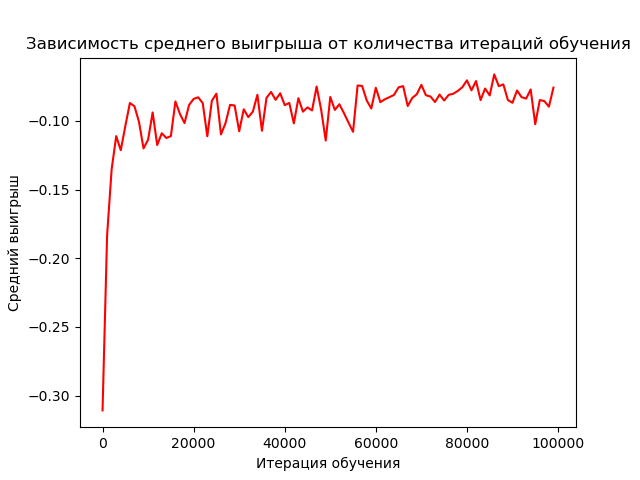

Best iteration value:  -0.3107
Best iteration value:  -0.1833
Best iteration value:  -0.135165
Best iteration value:  -0.11112
Best iteration value:  -0.10383
Best iteration value:  -0.08707
Best iteration value:  -0.0859
Best iteration value:  -0.084085
Best iteration value:  -0.08287
Best iteration value:  -0.080245
Best iteration value:  -0.079015
Best iteration value:  -0.07503
Best iteration value:  -0.074285
Best iteration value:  -0.07384
Best iteration value:  -0.07054
Best iteration value:  -0.06623

Best value:  -0.06623


In [12]:
%matplotlib notebook

ql.traning_model(n_train = 100000,
                show_fit = True,
                delta_show = 1000, 
                n_games = 100000)

In [44]:
simple_matrix_q = ql.get_best_matrix_q()

<IPython.core.display.Javascript object>


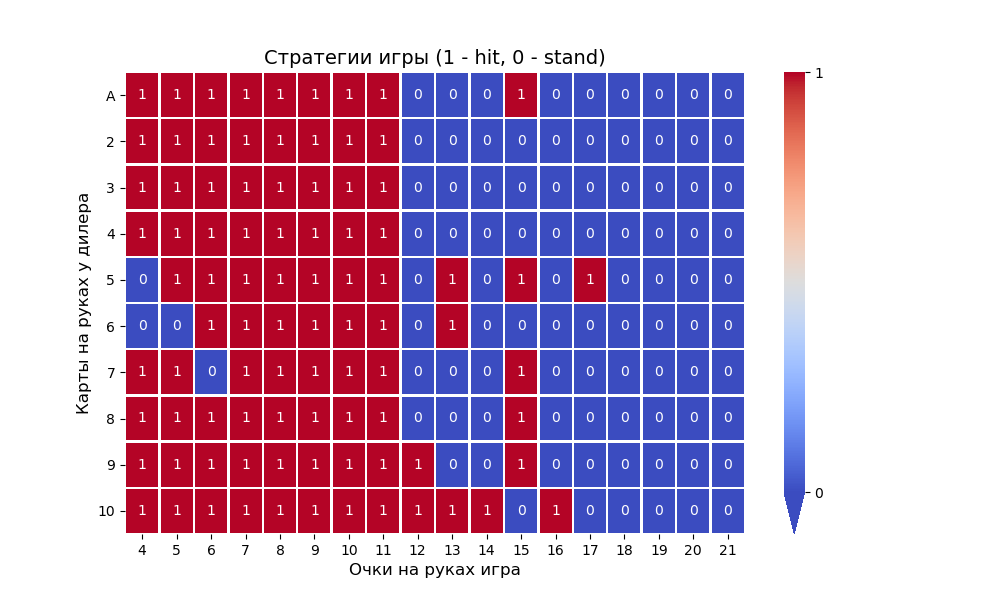

In [14]:
heat_map_plot(matrix=model.get_matrix_actions(simple_matrix_q, 18), double=False)

# Часть вторая, удвоенная

In [15]:
class DoubleModel(BaseModel):
    '''
    Простая модель игры в блэкджэк c возможнотью удвоения (action = 2)
    
    '''
    
    def __init__(self, natural=True, matrix_q=None, multiproc_game=False, n_cpu=mp.cpu_count()):
        super(DoubleModel, self).__init__(natural, matrix_q, multiproc_game, n_cpu)
        self.space_action = np.arange(3)
    
    
    def get_new_state(self, action):
        '''
        Возвращение нового состояния, награды и флага состояния игры после действия
        '''
        
        if action == 2:
            self.step(1)
            state, reward, done, _ = self.step(0)
            reward *= 2
                
        else:
            state, reward, done, _ = self.step(action)
        return state[0], reward, done
    
    
    def replace_matrix_q(self, new_matrix_q):
        """
        Замена текущей матрицы полезности
            new_matrix_q - матрица для замены
            
        """
        
        if isinstance(new_matrix_q, np.ndarray):
            size = new_matrix_q.shape
            assert size == (180, 3), 'Размер матрицы полезности должен быть 18x3'
            self._matrix_q = new_matrix_q
        else:
            self._matrix_q = np.random.rand(180, 3)
    

In [17]:
model = DoubleModel(multiproc_game=False)

In [18]:
ql = QLerning(model=model,
              alpha=0.1,
              gamma=0.5,
              epsilon=0.2,
             )

<IPython.core.display.Javascript object>


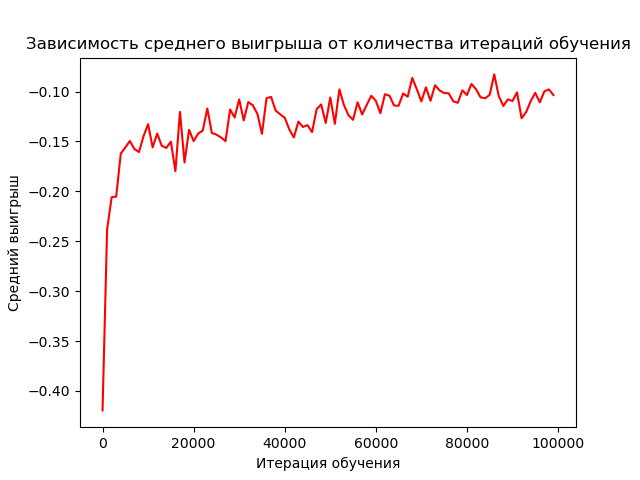

Best iteration value:  -0.41952
Best iteration value:  -0.23807
Best iteration value:  -0.20592
Best iteration value:  -0.205225
Best iteration value:  -0.16216
Best iteration value:  -0.15608
Best iteration value:  -0.14958
Best iteration value:  -0.14475
Best iteration value:  -0.13272
Best iteration value:  -0.12044
Best iteration value:  -0.11696
Best iteration value:  -0.107845
Best iteration value:  -0.1067
Best iteration value:  -0.10536
Best iteration value:  -0.09786
Best iteration value:  -0.08639
Best iteration value:  -0.08283

Best value:  -0.08283


In [19]:
%matplotlib notebook

ql.traning_model(n_train = 100000,
                show_fit = True,
                delta_show = 1000, 
                n_games = 100000,
                )

Матрица весов

In [20]:
double_matrix_q = ql.get_best_matrix_q()

<IPython.core.display.Javascript object>


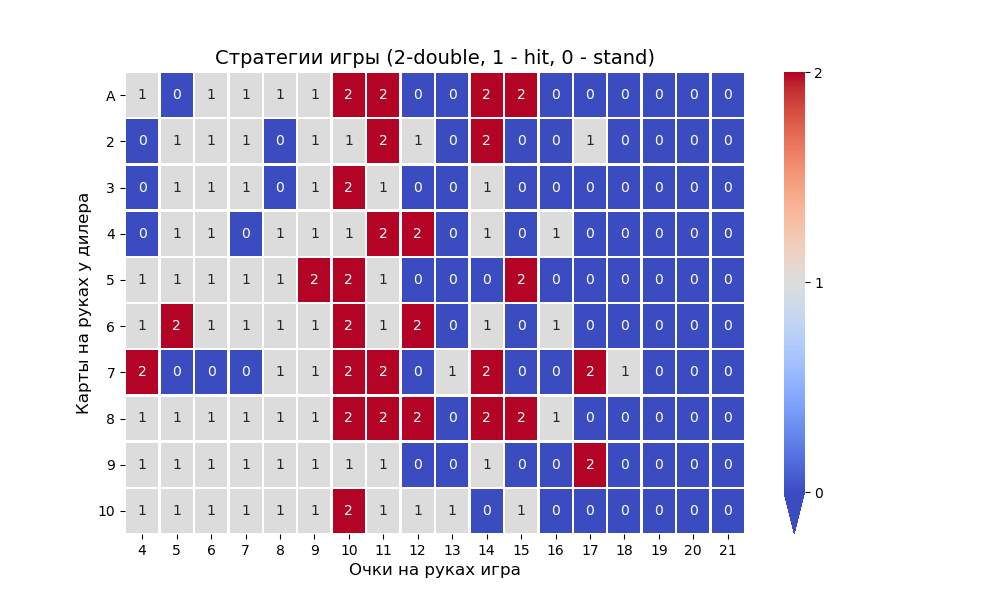

In [21]:
heat_map_plot(matrix=model.get_matrix_actions(double_matrix_q, 18), double=True)

# Часть третья, в главной роли — Дастин Хоффман

In [22]:
class Deck():
    """
    Класс определяющий объект колоды и операций над ней
        shufle_treshold - порог для перемешивания колоды. 
            Для перемещивания колоды воспользоваться методом shufle()
            Если в колоде карт больше, чем shufle_treshold, то перемещивание не произодет
        counts_shuffle - число раз перемещивания колоды
        model_score - модель подсчета карт
            "plus_minus" - модель "плюс-минус"
            "half" - модель "половинки"
    
    """
    
    def __init__(self, shufle_treshold=15, counts_shuffle=1, model_score="plus_minus"):
        self.deck = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]*4)
        self._card_drop_out = 0
        self._shufle_treshold = shufle_treshold
        self._counts_shuffle = counts_shuffle
        self.shufle()
        
        self._model_score = model_score
        self._model_score_cards = {"plus_minus":np.array([-1, 1, 1, 1, 1, 1, 0, 0, 0, -1]),
                                   "half":np.array([-1, 0.5, 1, 1, 1.5, 1, 0.5, 0, -0.5, -1])}
        self._deck_score = 0
      
    
    def shufle(self):
        '''
        Перемешивание карт в колоде
        
        '''
        
        for i in range(self._counts_shuffle):
            np.random.shuffle(self.deck)
        self._card_drop_out = 0
        self._deck_score = 0
        
        
    def need_shufle(self):
        '''
        Проверка необходимости перемешивать колоду
        
        '''
        
        if self._card_drop_out >= 52 - self._shufle_treshold:
            return True
        return False
    
    def get_card_from_deck(self, counts_card):
        '''
        Получение необходимого числа карт из колоды
        
        '''
        
        cards = self.deck[self._card_drop_out : self._card_drop_out + counts_card]
        self._card_drop_out += counts_card
        self._deck_score += self.solve_score(cards - 1)
        return cards
    
    
    def get_balance(self):
        '''
        Вернуть оставшееся число карт в колоде
        
        '''
        
        return int(52 - self._card_drop_out)
    
    
    def get_model_score_cards(self):
        '''
        Получение матрицы баллов карт в модели
        
        '''
        
        return self._model_score_cards[self._model_score]
    
    
    def get_score_deck(self):
        '''
        Получение текущих очков колоды
        
        '''
        
        return self._deck_score
    
    
    def solve_score(self, cards):
        '''
        Расчет суммы баллов карт
            cards - лист карт для подсчета очков
        
        '''
        
        if len(cards)>0:
            return sum(self._model_score_cards[self._model_score][cards])
        else:
            return 0

In [23]:
class HardModel(DoubleModel):
    '''
    
    Простая модель игры в блэкджэк
    
    '''
    
    def __init__(self, natural=True, matrix_q=None, multiproc_game=False, n_cpu=mp.cpu_count(),
                 shufle_treshold=15, counts_shuffle=1, model_score="plus_minus"):
        
        self.deck = Deck(shufle_treshold=shufle_treshold,
                         counts_shuffle=counts_shuffle,
                         model_score=model_score)

        super(HardModel, self).__init__(natural, matrix_q, multiproc_game, n_cpu)
    
    
    def replace_matrix_q(self, new_matrix_q):
        """
        Замена текущей матрицы полезности
            new_matrix_q - матрица для замены
        
        """
        
        if isinstance(new_matrix_q, np.ndarray):
            size = new_matrix_q.shape
            assert size == (738, 3), 'Размер матрицы полезности должен быть 738x3'
            self._matrix_q = new_matrix_q
        else:
            self._matrix_q = np.random.rand(738, 3)
    
    
    def _one_game_until_reset_deck(self,):
        sum_reward = 0
        party = 0
        self.reset_game()
        while self.deck.need_shufle() == False:
            done = False
            while done == False:
                action = self.choice_action(self._current_state)
                new_state, reward, done = self.get_new_state(action)
                if done == False:
                    self._current_state = new_state
            sum_reward += reward
            party += 1
            self.reset_game()
        return sum_reward, party 
    
    
    def step(self, action):
        assert self.action_space.contains(action)
        if action:  # hit: add a card to players hand and return
            self.player.append(self.draw_card(self.deck))
            if self.is_bust(self.player):
                done = True
                reward = -1.
            else:
                done = False
                reward = 0.
        else:  # stick: play out the dealers hand, and score
            done = True
            while self.sum_hand(self.dealer) < 17:
                self.dealer.append(self.draw_card(self.deck))
            reward = self.cmp(self.score(self.player), self.score(self.dealer))
            if self.natural and self.is_natural(self.player) and reward == 1.:
                reward = 1.5
        return self._get_obs(), reward, done, {}
    
    
    def reset(self):
        if self.deck.need_shufle():
            self.deck.shufle()
        self.dealer = self.draw_hand(self.deck)
        self.player = self.draw_hand(self.deck)
        return self._get_obs()
    
    
    def cmp(self, a, b):
        return float(a > b) - float(a < b)
    
    
    def convert_state_action_to_index_matrix_q(self, state, action):
        row = 18 * (self.deck.get_score_deck() + 20) + state - self._min_state
        return row, action
    
    
    def draw_card(self, deck):
        return int(deck.get_card_from_deck(1))
    
    
    def draw_hand(self, deck):
        return list(deck.get_card_from_deck(2))

    
    def usable_ace(self, hand):  # Does this hand have a usable ace?
        return 1 in hand and sum(hand) + 10 <= 21

    
    def sum_hand(self, hand):  # Return current hand total
        if self.usable_ace(hand):
            return sum(hand) + 10
        return sum(hand)

    
    def is_bust(self, hand):  # Is this hand a bust?
        return self.sum_hand(hand) > 21

    
    def score(self, hand):  # What is the score of this hand (0 if bust)
        return 0 if self.is_bust(hand) else self.sum_hand(hand)

    
    def is_natural(self, hand):  # Is this hand a natural blackjack?
        return sorted(hand) == [1, 10]

In [24]:
model = HardModel(multiproc_game=False)

In [25]:
ql = QLerning(model, alpha=0.1, gamma=0.5, epsilon=0.0)

<IPython.core.display.Javascript object>


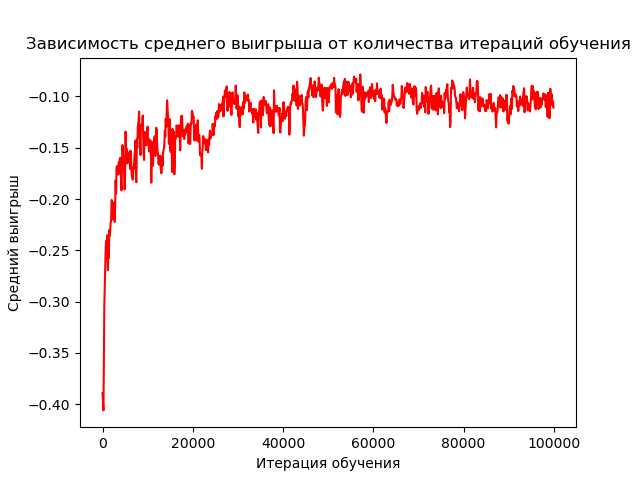

Best iteration value:  -0.389055
Best iteration value:  -0.348295
Best iteration value:  -0.30252
Best iteration value:  -0.282575
Best iteration value:  -0.263535
Best iteration value:  -0.247295
Best iteration value:  -0.24084
Best iteration value:  -0.235175
Best iteration value:  -0.23009
Best iteration value:  -0.229915
Best iteration value:  -0.222315
Best iteration value:  -0.221755
Best iteration value:  -0.20089
Best iteration value:  -0.181625
Best iteration value:  -0.16938
Best iteration value:  -0.167975
Best iteration value:  -0.164255
Best iteration value:  -0.162175
Best iteration value:  -0.15967
Best iteration value:  -0.14733
Best iteration value:  -0.13419
Best iteration value:  -0.12995
Best iteration value:  -0.1259
Best iteration value:  -0.1227
Best iteration value:  -0.11466
Best iteration value:  -0.103715
Best iteration value:  -0.10011
Best iteration value:  -0.094685
Best iteration value:  -0.093285
Best iteration value:  -0.09007
Best iteration value:  -0.

In [26]:
%matplotlib notebook
ql.traning_model(n_train = 100000,
                show_fit = True,
                delta_show = 100, 
                n_games = 100000)

Матрица весов

In [27]:
hard_matrix_q = ql.get_best_matrix_q()

<IPython.core.display.Javascript object>


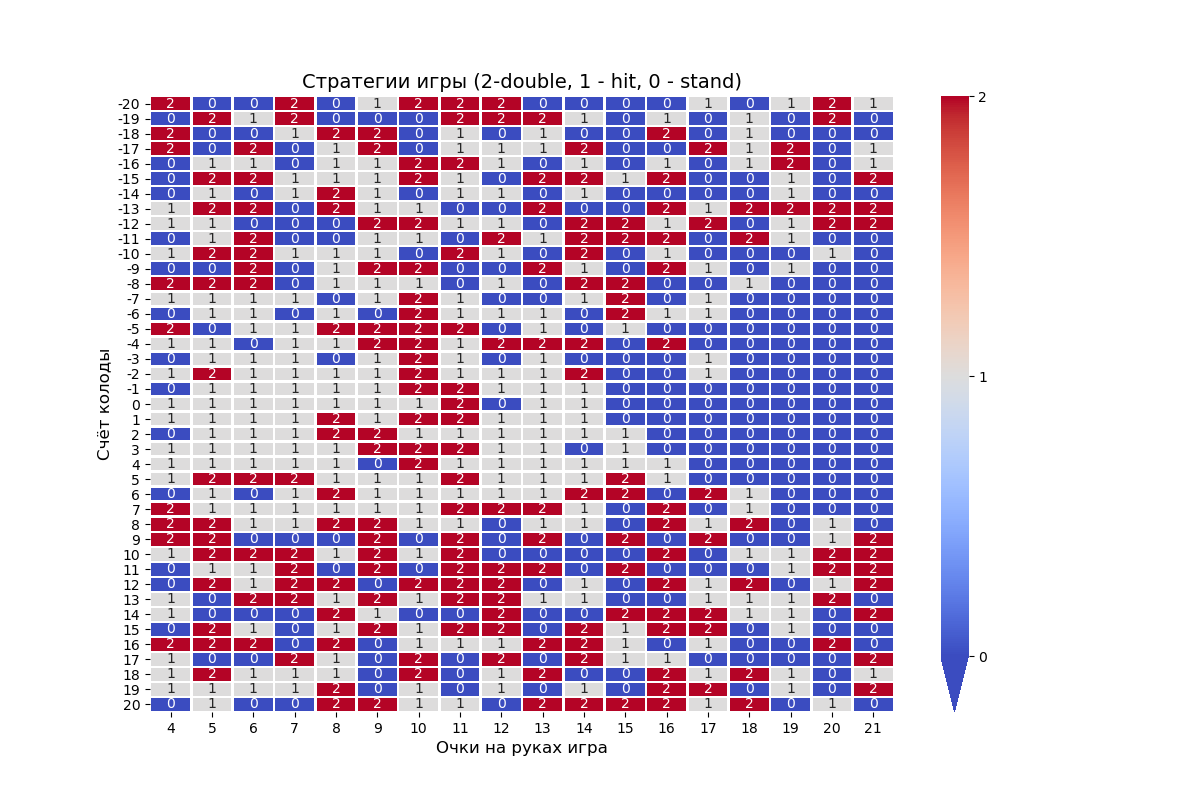

In [43]:
data = pd.DataFrame(model.get_matrix_actions(hard_matrix_q, 18))
data.columns = list(map(str, np.arange(4, 22)))
data.index = list(map(str, np.arange(-20, 21)))

plt.figure(figsize=(12, 8)) 

cbar_kws = {"orientation": "vertical", 
            "shrink":1,
            'extend':'min', 
            'extendfrac':0.1, 
            "ticks":np.arange(0, 3), 
            "drawedges":False, 
           }

sns.heatmap(data,
            vmin=0,
            vmax=2,
            cmap="coolwarm",
            annot = True,
            linewidth = 1,
            cbar_kws=cbar_kws)

plt.yticks(rotation=0) 

plt.title('Стратегии игры (2-double, 1 - hit, 0 - stand)', fontsize=14)
plt.xlabel("Очки на руках игра", fontsize=12)
plt.ylabel("Счёт колоды", fontsize=12)
plt.show()